# Preparing system

In [1]:
import setGPU

setGPU: Setting GPU to: 1


In [2]:
# limit GPU usage
import sys
import tensorflow as tf
gpuFraction = 0.4
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpuFraction)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
import keras
from keras import backend as K
K.set_session(sess)
print('using gpu memory fraction: '+str(gpuFraction))

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


using gpu memory fraction: 0.4


Using TensorFlow backend.


In [3]:
%matplotlib inline

In [4]:
import h5py
import glob
import numpy as np


In [5]:
# need afs password to read from eos
import os
import getpass
os.system("echo %s| kinit" %getpass.getpass())

········


0

# Import files

In [6]:
# open the new dataset
fileIn = h5py.File("ZtoNuNu_lepFilter_13TeV_JetImage_3.h5")
#delphesPt = fileIn.get("jetSmearedDelphes")
print(list(fileIn.keys()))

['jetECALImages', 'jetHCALImages', 'jetMomenta', 'jetTrkImages', 'rawJetMomenta', 'trkList']


In [7]:
truth = fileIn.get("jetMomenta")
raw = fileIn.get("rawJetMomenta")
eCal = fileIn.get("jetECALImages")
hCal = fileIn.get("jetHCALImages")
track = fileIn.get("jetTrkImages")
trkList = fileIn.get("trkList")
print(eCal.shape, hCal.shape, track.shape, trkList.shape)

(526218, 25, 25) (526218, 5, 5) (526218, 25, 25) (526218, 50, 3)


# image preparations

In [8]:
# eCal
sumeCal = np.sum(eCal,axis=0)
print(sumeCal.shape)

(25, 25)


In [9]:
eCalImage = sumeCal[:,:]
print(eCalImage.shape)

(25, 25)


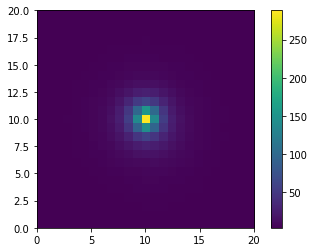

In [10]:
import matplotlib.pyplot as plt
plt.imshow(eCalImage/eCalImage.shape[0], extent=[0, 20, 0, 20], origin='lower')
plt.colorbar()

In [11]:
# hCal
sumhCal = np.sum(hCal,axis=0)
print(sumhCal.shape)

(5, 5)


In [12]:
hCalImage = sumhCal[:,:]
print(hCalImage.shape)

(5, 5)


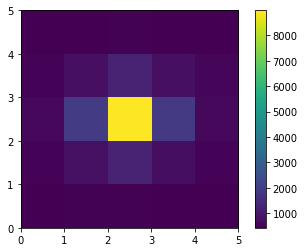

In [13]:
plt.imshow(hCalImage/(hCalImage.shape[0]), extent=[0, 5, 0, 5], origin='lower')
plt.colorbar()

In [14]:
# trk
sumTrk= np.sum(track,axis=0)
print(sumTrk.shape)

(25, 25)


In [15]:
trkImage = sumTrk[:,:]
print(trkImage.shape)

(25, 25)


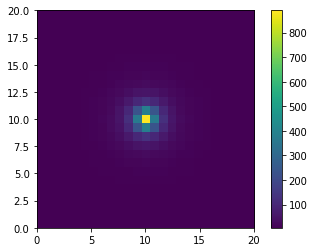

In [16]:
plt.imshow(trkImage/trkImage.shape[0], extent=[0, 20, 0, 20], origin='lower')
plt.colorbar()

# Prepare train and test samples



In [17]:
from sklearn.preprocessing import MinMaxScaler
# normalize raw inputs and outputs between 0 and 1
scaler = MinMaxScaler()
print(scaler.fit(raw))
maxVal = scaler.data_max_
minVal = scaler.data_min_
raw = (raw-minVal)/(maxVal-minVal)
truth = (truth-minVal)/(maxVal-minVal)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [18]:
truth = truth[:,0]
truth = np.reshape(truth, (truth.shape[0], 1))

In [19]:
iSplit = int(0.7*truth.shape[0])
eCal_image_train = eCal[:iSplit, :, :]
eCal_image_test = eCal[iSplit:, :, :]
hCal_image_train = hCal[:iSplit, :, :]
hCal_image_test = hCal[iSplit:, :, :]
trk_image_train = track[:iSplit, :, :]
trk_image_test = track[iSplit:, :, :]
lst_train = trkList[:iSplit, :, :]
lst_test = trkList[iSplit:,:,:]
raw_train = raw[:iSplit, :]
raw_test = raw[iSplit:, :]
y_train = truth[:iSplit, :]
y_test = truth[iSplit:, :]

In [20]:
eCal_image_test = np.reshape(eCal_image_test, (eCal_image_test.shape[0], eCal_image_test.shape[1],
                                         eCal_image_test.shape[2], 1))
eCal_image_train = np.reshape(eCal_image_train, (eCal_image_train.shape[0], eCal_image_train.shape[1],
                                           eCal_image_train.shape[2], 1))

In [21]:
hCal_image_test = np.reshape(hCal_image_test, (hCal_image_test.shape[0], hCal_image_test.shape[1],
                                         hCal_image_test.shape[2], 1))
hCal_image_train = np.reshape(hCal_image_train, (hCal_image_train.shape[0], hCal_image_train.shape[1],
                                           hCal_image_train.shape[2], 1))

In [22]:
trk_image_test = np.reshape(trk_image_test, (trk_image_test.shape[0], trk_image_test.shape[1],
                                         trk_image_test.shape[2], 1))
trk_image_train = np.reshape(trk_image_train, (trk_image_train.shape[0], trk_image_train.shape[1],
                                           trk_image_train.shape[2], 1))

In [23]:
lst_test = np.reshape(lst_test, (lst_test.shape[0], lst_test.shape[1],
                                         lst_test.shape[2], 1))
lst_train = np.reshape(lst_train, (lst_train.shape[0], lst_train.shape[1],
                                           lst_train.shape[2], 1))

# build the model

In [24]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Conv1D, Dropout, Flatten, Concatenate, Reshape, BatchNormalization
from keras.layers import MaxPooling2D, MaxPooling3D, GRU
from keras.utils import plot_model
from keras import regularizers
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [25]:
batch_size = 128

In [26]:
InputRaw = Input(shape=(4,))
inputeCal = Input(shape=(25,25,1))
inputhCal = Input(shape=(5,5,1))
inputTrk = Input(shape=(25,25,1))
inputList = Input(shape=(50,3,1))

In [27]:
x2 = BatchNormalization()(InputRaw)

In [28]:
e = BatchNormalization()(inputeCal)
e = Conv2D(30, kernel_size=(3, 3), activation='selu', data_format="channels_last", strides=(1, 1), input_shape=(25,25,1))(e)
e = Dropout(0.25)(e)
e = Conv2D(20, kernel_size=(3,3), strides=(1,1), activation='selu')(e)
e = Dropout(0.25)(e)
e = Flatten()(e)

h = BatchNormalization()(inputhCal)
h = Conv2D(20, kernel_size=(3, 3), data_format="channels_last", strides=(3, 3), activation='selu', input_shape=(5,5,1))(h)
h = Dropout(0.25)(h)
#h = Reshape((1, 1), input_shape=(1, 1, 1))(h)
h = Flatten()(h)

In [29]:
t = BatchNormalization()(inputTrk)
t = Conv2D(30, kernel_size=(3, 3), data_format="channels_last", strides=(3, 3), activation='relu', input_shape=(25,25,1))(t)
t = Dropout(0.25)(t)
#t = Reshape((8, 8), input_shape=(8, 8, 1))(t)
t = Conv2D(20, kernel_size=(3,3), strides=(3, 3), activation='relu')(t)
t = Dropout(0.25)(t)
t = Flatten()(t)

In [30]:
tl1 = BatchNormalization()(inputList)
tl1 = Conv2D(2, kernel_size=(1,3), strides=(1,3),activation='selu',padding='same')(tl1)
tl1 = Dropout(0.25)(tl1)
tl1 = Conv2D(1, kernel_size=(1,2), strides=(1,2),activation='selu',padding='same')(tl1)
tl1 = Dropout(0.25)(tl1)
tl1 = Flatten()(tl1)

In [31]:
tlg = BatchNormalization()(inputList)
print(tlg.shape)
# first inner later
tlg = Reshape((50,3))(tlg)
tlg = GRU(3, activation='selu', recurrent_activation='hard_sigmoid')(tlg)

(?, 50, 3, 1)


In [32]:
denseImg = Concatenate(axis=1)([x2, e, h, t])
denseImg = Dense(20, activation='selu')(denseImg)
denseImg = Dropout(0.25)(denseImg)
denseImg = Dense(10, activation='selu')(denseImg)
denseImg = Dropout(0.25)(denseImg)
outputImg = Dense(1, activation='linear')(denseImg)

In [33]:
denseConv = Concatenate(axis=1)([x2, e, h, tl1])
denseConv = Dense(20, activation='selu')(denseConv)
denseConv = Dropout(0.25)(denseConv)
denseConv = Dense(10, activation='selu')(denseConv)
denseConv = Dropout(0.25)(denseConv)
outputConv = Dense(1, activation='linear')(denseConv)

In [34]:
denseGRU = Concatenate(axis=1)([x2, e, h, tlg])
denseGRU = Dense(20, activation='selu')(denseGRU)
denseGRU = Dropout(0.25)(denseGRU)
denseGRU = Dense(10, activation='selu')(denseGRU)
denseGRU = Dropout(0.25)(denseGRU)
outputGRU = Dense(1, activation='linear')(denseGRU)

In [35]:
modelImg = Model(inputs=[InputRaw,inputeCal, inputhCal, inputTrk, inputList], outputs=outputImg)

In [36]:
modelConv = Model(inputs=[InputRaw,inputeCal, inputhCal, inputTrk, inputList], outputs=outputConv)

In [37]:
modelGRU = Model(inputs=[InputRaw,inputeCal, inputhCal, inputTrk, inputList], outputs=outputGRU)

In [38]:
modelImg.compile(loss='mse', optimizer='adam')
modelImg.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 25, 25, 1)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 25, 25, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 25, 25, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 25, 25, 1)    4           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (

In [39]:
modelConv.compile(loss='mse', optimizer='adam')
modelConv.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 25, 25, 1)    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 50, 3, 1)     0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 25, 25, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 50, 3, 1)     4           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (

In [40]:
modelGRU.compile(loss='mse', optimizer='adam')
modelGRU.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 25, 25, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 25, 25, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 23, 23, 30)   300         batch_normalization_2[0][0]      
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 5, 5, 1)      0                                            
__________________________________________________________________________________________________
dropout_1 

In [41]:
# train 
historyImg = modelImg.fit([raw_train, eCal_image_train, hCal_image_train, trk_image_train, lst_train], y_train, epochs=100, batch_size=batch_size, verbose = 1,
                validation_data=([raw_test, eCal_image_test, hCal_image_test, trk_image_test, lst_test], y_test),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 368352 samples, validate on 157866 samples
Epoch 1/100
368352/368352 [==============================] - 46s 124us/step - loss: 0.0047 - val_loss: 8.9369e-05
Epoch 2/100
368352/368352 [==============================] - 44s 120us/step - loss: 1.8000e-04 - val_loss: 6.9523e-05
Epoch 3/100
368352/368352 [==============================] - 43s 115us/step - loss: 1.6696e-04 - val_loss: 6.0163e-05

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/100
368352/368352 [==============================] - 44s 119us/step - loss: 1.2998e-04 - val_loss: 5.2477e-05
Epoch 5/100
368352/368352 [==============================] - 44s 119us/step - loss: 1.2770e-04 - val_loss: 5.6596e-05

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 6/100
368352/368352 [==============================] - 44s 119us/step - loss: 1.2122e-04 - val_loss: 5.2981e-05
Epoch 7/100
368352/368352 [==============================] - 45s 121us/step - lo

In [42]:
historyConv = modelConv.fit([raw_train, eCal_image_train, hCal_image_train, trk_image_train, lst_train], y_train, epochs=100, batch_size=batch_size, verbose = 1,
                validation_data=([raw_test, eCal_image_test, hCal_image_test, trk_image_test, lst_test], y_test),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 368352 samples, validate on 157866 samples
Epoch 1/100
368352/368352 [==============================] - 41s 111us/step - loss: 4.1143e-04 - val_loss: 6.8379e-05
Epoch 2/100
368352/368352 [==============================] - 41s 111us/step - loss: 1.5297e-04 - val_loss: 6.7309e-05
Epoch 3/100
368352/368352 [==============================] - 41s 111us/step - loss: 1.4123e-04 - val_loss: 7.8895e-05

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/100
368352/368352 [==============================] - 41s 111us/step - loss: 1.2136e-04 - val_loss: 5.4974e-05
Epoch 5/100
368352/368352 [==============================] - 43s 116us/step - loss: 1.2114e-04 - val_loss: 5.6674e-05

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 6/100
368352/368352 [==============================] - 40s 109us/step - loss: 1.2119e-04 - val_loss: 5.4820e-05
Epoch 7/100
368352/368352 [==============================] - 39s 105us/step 

In [43]:
historyGRU = modelGRU.fit([raw_train, eCal_image_train, hCal_image_train, trk_image_train, lst_train], y_train, epochs=100, batch_size=batch_size, verbose = 1,
                validation_data=([raw_test, eCal_image_test, hCal_image_test, trk_image_test, lst_test], y_test),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 368352 samples, validate on 157866 samples
Epoch 1/100
368352/368352 [==============================] - 115s 312us/step - loss: 1.9860e-04 - val_loss: 9.9133e-05
Epoch 2/100
368352/368352 [==============================] - 113s 307us/step - loss: 1.7013e-04 - val_loss: 7.1654e-05
Epoch 3/100
368352/368352 [==============================] - 114s 308us/step - loss: 1.2970e-04 - val_loss: 6.3052e-05

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/100
368352/368352 [==============================] - 113s 306us/step - loss: 1.1895e-04 - val_loss: 5.9347e-05
Epoch 5/100
368352/368352 [==============================] - 112s 303us/step - loss: 1.1975e-04 - val_loss: 5.4781e-05

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 6/100
368352/368352 [==============================] - 112s 304us/step - loss: 1.1861e-04 - val_loss: 5.5288e-05
Epoch 7/100
368352/368352 [==============================] - 111s 303u

# Analysis

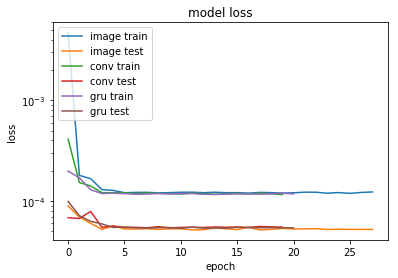

In [60]:
# plot training history
plt.plot(historyImg.history['loss'])
plt.plot(historyImg.history['val_loss'])
plt.plot(historyConv.history['loss'])
plt.plot(historyConv.history['val_loss'])
plt.plot(historyGRU.history['loss'])
plt.plot(historyGRU.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['image train', 'image test', 'conv train', 'conv test','gru train','gru test'], loc='upper left')
plt.show()
#

In [61]:
ImgPredict = modelImg.predict([raw_test, eCal_image_test, hCal_image_test, trk_image_test, lst_test])
ImgPredict = np.reshape(ImgPredict, (ImgPredict.shape[0],))

In [62]:
ConvPredict = modelConv.predict([raw_test, eCal_image_test, hCal_image_test, trk_image_test, lst_test])
ConvPredict = np.reshape(ConvPredict, (ConvPredict.shape[0],))

In [63]:
GRUPredict = modelGRU.predict([raw_test, eCal_image_test, hCal_image_test, trk_image_test, lst_test])
GRUPredict = np.reshape(GRUPredict, (GRUPredict.shape[0],))

In [64]:
#put pT back in its range
#delphesPt = minVal[0] + np.reshape(delphesPt, (delphesPt.shape[0],))*(maxVal[0]-minVal[0])
pTraw = minVal[0] + raw_test[:,0]*(maxVal[0]-minVal[0])
pTreco = minVal[0] + np.reshape(y_test, (y_test.shape[0],))*(maxVal[0]-minVal[0])
ImgPredict = minVal[0] + ImgPredict*(maxVal[0]-minVal[0])
ConvPredict = minVal[0] + ConvPredict*(maxVal[0]-minVal[0])
GRUPredict = minVal[0] + GRUPredict*(maxVal[0]-minVal[0])

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


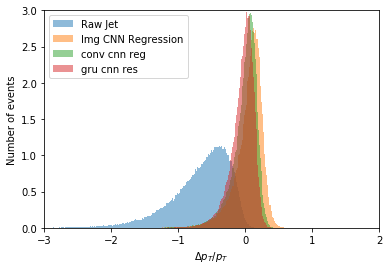

RAW MEAN: -0.667510
RAW RMS: 0.447229
-------------------
img CNN MEAN: 0.056017
img CNN RMS: 0.210287
-------------------
conv CNN MEAN: -0.005295
conv CNN RMS: 0.194822
-------------------
gru CNN MEAN: -0.042430
gru CNN RMS: 0.183721


In [97]:
plt.xlim(-3., 2.)
# histtype = 'step'
plt.ylim(0.,3.)
resRaw = np.nan_to_num((pTreco-pTraw)/pTreco)
ImgresCNN = np.nan_to_num((pTreco-ImgPredict)/pTreco)
ConvresCNN = np.nan_to_num((pTreco-ConvPredict)/pTreco)
GRUresCNN = np.nan_to_num((pTreco-GRUPredict)/pTreco)
#resDelphes = np.nan_to_num((pTreco-delphesPt)/pTreco)
plt.hist(resRaw, bins = 500, normed=1, alpha = 0.5)
plt.hist(ImgresCNN, bins = 500, normed=1, alpha = 0.5)
plt.hist(ConvresCNN, bins = 500, normed=1, alpha = 0.5)
plt.hist(GRUresCNN, bins = 500, normed=1, alpha = 0.5)
#plt.hist(resDelphes, bins = 500, normed=1, alpha = 0.8)
plt.ylabel('Number of events')
plt.xlabel('$\Delta p_T/p_T$')
#plt.legend(['Raw Jet','CNN Regression', 'Trigger PFJet'], loc='upper left')
plt.legend(['Raw Jet','Img CNN Regression','conv cnn reg','gru cnn res'], loc='upper left')
plt.show()
from scipy.stats import norm
(mu, sigma) = norm.fit(resRaw)
print("RAW MEAN: %f" %mu)
print("RAW RMS: %f" %sigma)
print("-------------------")
(mu, sigma) = norm.fit(ImgresCNN)
print("img CNN MEAN: %f" %mu)
print("img CNN RMS: %f" %sigma)
print("-------------------")
(mu, sigma) = norm.fit(ConvresCNN)
print("conv CNN MEAN: %f" %mu)
print("conv CNN RMS: %f" %sigma)
print("-------------------")
(mu, sigma) = norm.fit(GRUresCNN)
print("gru CNN MEAN: %f" %mu)
print("gru CNN RMS: %f" %sigma)

In [83]:
ImgPredict_reshaped = minVal[0] + ImgPredict*(maxVal[0]-minVal[0])

In [84]:
print(ImgPredict_reshaped)

[20782.8    13789.4795 51365.07   ... 14676.613  20719.701  17806.291 ]


In [85]:
print(ImgPredict)

[24.679459 16.370323 61.01588  ... 17.424374 24.604488 21.14291 ]


In [86]:
over = ImgPredict > 100

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


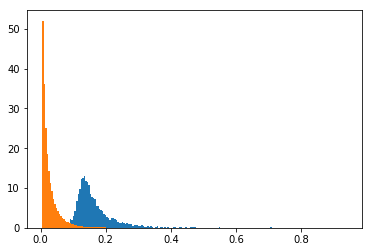

In [87]:
plt.hist(y_test[over==1], bins=200, normed=1)
plt.hist(y_test, bins=200, normed=1)
plt.show()

In [70]:
thresh = 40

In [90]:
myTestArray_sig_Img = y_test[over==1] > 0.01
myTestArray_bkg_Img = y_test[over==0] > 0.01
print("Img True Positive Rate %f" %(myTestArray_sig_Img.sum()/float((over==1).sum())))
print("Img False Positive Rate %f" %(myTestArray_bkg_Img.sum()/float((over==0).sum())))

Img True Positive Rate 0.999690
Img False Positive Rate 0.701943


# baseline turn-on curve: just use the raw pT estimate

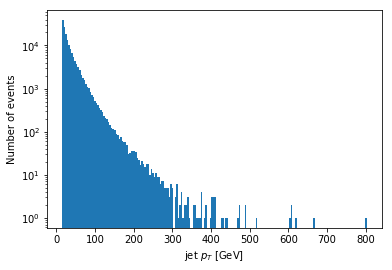

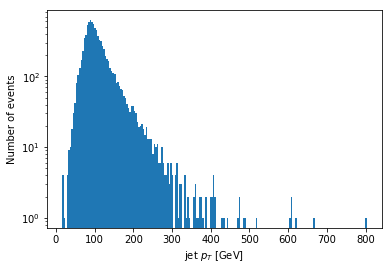

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


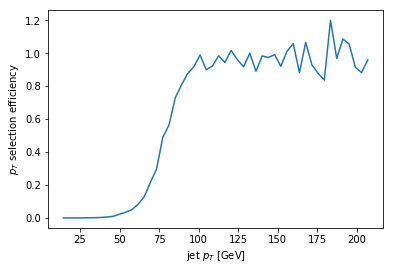

0.056693651577920515


In [91]:
thresh = 100.
alljet_pt = pTreco
#alljet_pt = alljet_pt.reshape((len(alljet_pt),1))
goodjets = pTraw>thresh
goodjet_pt = alljet_pt[goodjets]
countsAllJets, bins, bars = plt.hist(alljet_pt, bins=200)
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("Number of events")
plt.yscale('log')
plt.show()
# numerator: only jets estimated to be > 40 GeV (score ) 
countsGoodJets, bins, bars = plt.hist(goodjet_pt, bins=200)
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("Number of events")
plt.yscale('log')
plt.show()
# recenter the bins
half_bin_width = (bins[1]-bins[0])/2.
bins = bins - half_bin_width
# plot the ratio
ratio = countsGoodJets/countsAllJets
plt.plot(bins[0:50], ratio[0:50])
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("$p_T$ selection efficiency")
plt.show()
# fraction of events that passed the threshold
print(float(goodjets.sum())/len(goodjets))

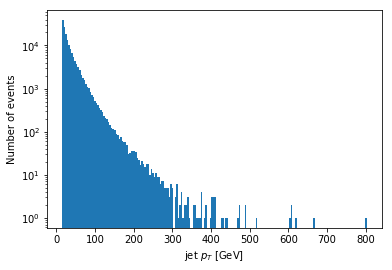

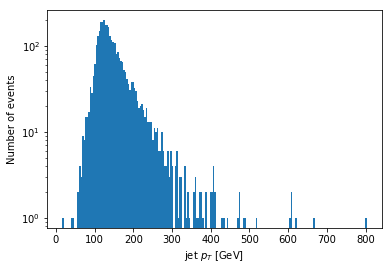

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


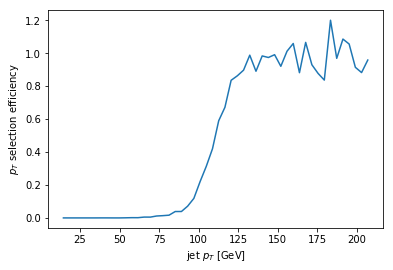

0.020466724943939796


In [92]:
thresh = 100.
alljet_pt = pTreco
#alljet_pt = alljet_pt.reshape((len(alljet_pt),1))
goodjets = ImgPredict>thresh
goodjet_pt = alljet_pt[goodjets]
countsAllJets, bins, bars = plt.hist(alljet_pt, bins=200)
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("Number of events")
plt.yscale('log')
plt.show()
# numerator: only jets estimated to be > 40 GeV (score ) 
countsGoodJets, bins, bars = plt.hist(goodjet_pt, bins=200)
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("Number of events")
plt.yscale('log')
plt.show()
# recenter the bins
half_bin_width = (bins[1]-bins[0])/2.
bins = bins - half_bin_width
# plot the ratio
ratio = countsGoodJets/countsAllJets
plt.plot(bins[0:50], ratio[0:50])
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("$p_T$ selection efficiency")
plt.show()
# fraction of events that passed the threshold
print(float(goodjets.sum())/len(goodjets))

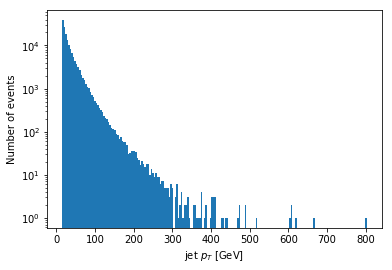

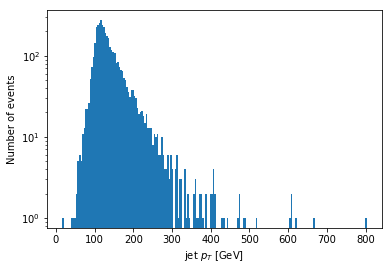

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


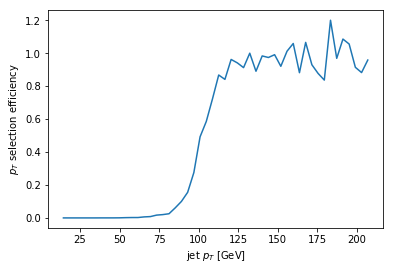

0.025337944839294083


In [93]:
thresh = 100.
alljet_pt = pTreco
#alljet_pt = alljet_pt.reshape((len(alljet_pt),1))
goodjets = ConvPredict>thresh
goodjet_pt = alljet_pt[goodjets]
countsAllJets, bins, bars = plt.hist(alljet_pt, bins=200)
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("Number of events")
plt.yscale('log')
plt.show()
# numerator: only jets estimated to be > 40 GeV (score ) 
countsGoodJets, bins, bars = plt.hist(goodjet_pt, bins=200)
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("Number of events")
plt.yscale('log')
plt.show()
# recenter the bins
half_bin_width = (bins[1]-bins[0])/2.
bins = bins - half_bin_width
# plot the ratio
ratio = countsGoodJets/countsAllJets
plt.plot(bins[0:50], ratio[0:50])
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("$p_T$ selection efficiency")
plt.show()
# fraction of events that passed the threshold
print(float(goodjets.sum())/len(goodjets))

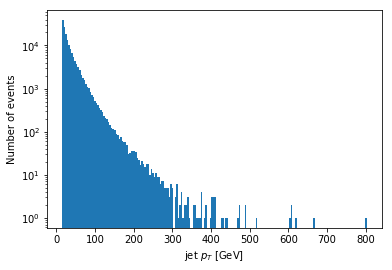

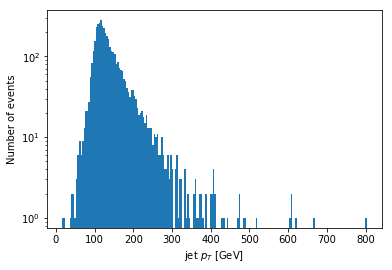

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


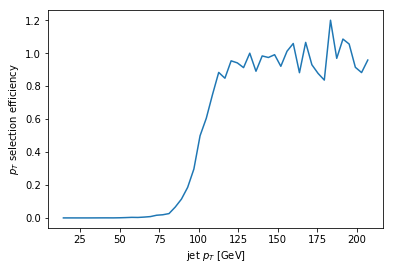

0.025819365791240674


In [94]:
thresh = 100.
alljet_pt = pTreco
#alljet_pt = alljet_pt.reshape((len(alljet_pt),1))
goodjets = GRUPredict>thresh
goodjet_pt = alljet_pt[goodjets]
countsAllJets, bins, bars = plt.hist(alljet_pt, bins=200)
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("Number of events")
plt.yscale('log')
plt.show()
# numerator: only jets estimated to be > 40 GeV (score ) 
countsGoodJets, bins, bars = plt.hist(goodjet_pt, bins=200)
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("Number of events")
plt.yscale('log')
plt.show()
# recenter the bins
half_bin_width = (bins[1]-bins[0])/2.
bins = bins - half_bin_width
# plot the ratio
ratio = countsGoodJets/countsAllJets
plt.plot(bins[0:50], ratio[0:50])
plt.xlabel("jet $p_T$ [GeV]")
plt.ylabel("$p_T$ selection efficiency")
plt.show()
# fraction of events that passed the threshold
print(float(goodjets.sum())/len(goodjets))